# M4ESTRO - Alpha parameters optimization

## Imports

In [1]:
from typing import Dict, Any, List, Optional, Set, Tuple, Callable
import json
from datetime import datetime, timedelta
import logging
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
ESTIMATIONS_PATH: str = "./results/v1/train/estimations.json"

CSV_PATH: str = "C:/P/backend/LambdaPY/graph_manager/builder_service/local/csv_test"

## Data preparation

In [3]:
orders_df = pd.read_csv(f"{CSV_PATH}/order_train.csv")
orders_df.tail()

id  manufacturer_id  manufacturer_order_id  site_id  carrier_id  \
83  102                1                   8134        3           2   
84  103                1                   8157        3           2   
85  104                1                   8194        3           2   
86  105                1                   8197        3           2   
87  106                1                   8224        3           2   

       status  n_steps                                      tracking_link  \
83  DELIVERED       12  https://www.ups.com/track?tracknum=1ZR46591041...   
84  DELIVERED       11  https://www.ups.com/track?tracknum=1ZR46591041...   
85  DELIVERED       11  https://www.ups.com/track?tracknum=1ZR46591041...   
86  DELIVERED       11  https://www.ups.com/track?tracknum=1ZR46591041...   
87  DELIVERED       12  https://www.ups.com/track?tracknum=1ZR46591041...   

       tracking_number manufacturer_creation_timestamp  \
83  1ZR465910413370335       2025-07-14 14:38:00+00:00   
84  1ZR465910413372002       2025-07-16 11:35:00+00:00   
85  1ZR465910413373832       2025-07-18 10:52:00+00:00   
86  1ZR465910413373841       2025-07-18 12:03:00+00:00   
87  1ZR465910413374788       2025-07-21 07:18:00+00:00   

   manufacturer_estimated_delivery_timestamp  \
83                 2025-07-17 20:00:00+00:00   
84                 2025-07-20 20:00:00+00:00   
85                 2025-07-23 20:00:00+00:00   
86                 2025-07-20 20:00:00+00:00   
87                 2025-07-24 20:00:00+00:00   

   manufacturer_confirmed_delivery_timestamp carrier_creation_timestamp  \
83                 2025-07-21 06:06:00+00:00  2025-07-15 13:13:00+00:00   
84                 2025-07-17 22:00:00+00:00  2025-07-16 22:47:00+00:00   
85                 2025-07-20 22:00:00+00:00  2025-07-18 22:56:00+00:00   
86                 2025-07-20 22:00:00+00:00  2025-07-18 22:53:00+00:00   
87                 2025-07-22 22:00:00+00:00  2025-07-21 20:01:00+00:00   

    carrier_estimated_delivery_timestamp carrier_confirmed_delivery_timestamp  \
83                                   NaN            2025-07-17 14:50:00+00:00   
84                                   NaN            2025-07-18 11:39:00+00:00   
85                                   NaN            2025-07-21 14:18:00+00:00   
86                                   NaN            2025-07-21 14:18:00+00:00   
87                                   NaN            2025-07-23 08:21:00+00:00   

    SLS  SRS  
83    0    0  
84    0    0  
85    0    0  
86    0    0  
87    0    0

In [4]:
orders_df['manufacturer_creation_timestamp'] = pd.to_datetime(orders_df['manufacturer_creation_timestamp'], utc=True)
orders_df['carrier_confirmed_delivery_timestamp'] = pd.to_datetime(orders_df['carrier_confirmed_delivery_timestamp'], utc=True)
orders_df['carrier_creation_timestamp'] = pd.to_datetime(orders_df['carrier_creation_timestamp'], utc=True)

orders_df['dispatch_hours'] = (orders_df['carrier_creation_timestamp'] - orders_df['manufacturer_creation_timestamp']).dt.total_seconds() / 3600.0
orders_df['shipment_hours'] = (orders_df['carrier_confirmed_delivery_timestamp'] - orders_df['carrier_creation_timestamp']).dt.total_seconds() / 3600.0
orders_df['delivery_hours'] = orders_df['dispatch_hours'] + orders_df['shipment_hours']


orders_df.head()

id  manufacturer_id  manufacturer_order_id  site_id  carrier_id     status  \
0   1                1                   6004        8           1  DELIVERED   
1   2                1                   6005        1           2  DELIVERED   
2   3                1                   6037        3           2  DELIVERED   
3   4                1                   6045        3           2  DELIVERED   
4   5                1                   6046        4           3  DELIVERED   

   n_steps                                      tracking_link  \
0       14  https://mydhl.express.dhl/it/it/tracking.html#...   
1       11                                 1Z60699Y0400391867   
2       11                                 1ZR465910413218509   
3       12  https://www.digikey.it/OrderHistory/shipmenttr...   
4       14  https://www.fedex.com/fedextrack/?trknbr=43744...   

      tracking_number manufacturer_creation_timestamp  \
0          1656325344       2025-01-07 07:31:00+00:00   
1  1Z60699Y0400391867       2025-01-07 13:57:00+00:00   
2  1ZR465910413218509       2025-01-10 13:41:00+00:00   
3  1ZR465910413219320       2025-01-13 15:27:00+00:00   
4        437446419489       2025-01-13 15:27:00+00:00   

  manufacturer_estimated_delivery_timestamp  \
0                 2025-01-13 22:00:00+00:00   
1                 2025-01-08 22:00:00+00:00   
2                 2025-01-14 22:00:00+00:00   
3                 2025-01-15 22:00:00+00:00   
4                 2025-01-15 22:00:00+00:00   

  manufacturer_confirmed_delivery_timestamp carrier_creation_timestamp  \
0                 2025-01-17 11:36:00+00:00  2025-01-14 09:16:00+00:00   
1                 2025-01-13 12:47:00+00:00  2025-01-09 03:11:00+00:00   
2                 2025-01-15 09:18:00+00:00  2025-01-11 00:10:00+00:00   
3                 2025-01-15 09:45:00+00:00  2025-01-13 17:08:00+00:00   
4                 2025-01-15 12:14:00+00:00  2025-01-13 20:15:00+00:00   

   carrier_estimated_delivery_timestamp carrier_confirmed_delivery_timestamp  \
0                                   NaN            2025-01-17 10:40:00+00:00   
1                                   NaN            2025-01-13 09:19:00+00:00   
2                                   NaN            2025-01-15 09:47:00+00:00   
3                                   NaN            2025-01-15 09:47:00+00:00   
4                                   NaN            2025-01-15 11:49:00+00:00   

   SLS  SRS  dispatch_hours  shipment_hours  delivery_hours  
0    0    0      169.750000       73.400000      243.150000  
1    0    0       37.233333      102.133333      139.366667  
2    0    0       10.483333      105.616667      116.100000  
3    0    0        1.683333       40.650000       42.333333  
4    0    0        4.800000       39.566667       44.366667

In [5]:
dispatch_time_by_order_id: Dict[str, float] = {
    row["id"]: row["dispatch_hours"]
    for _, row in orders_df.iterrows()
}

shipment_time_by_order_id: Dict[str, float] = {
    row["id"]: row["shipment_hours"]
    for _, row in orders_df.iterrows()
}

assert len(dispatch_time_by_order_id) == len(orders_df)
assert len(shipment_time_by_order_id) == len(orders_df)

In [6]:
with open(ESTIMATIONS_PATH, 'r') as file:
    estimations: Dict[str, Any] = json.load(file)

estimations

{'dispatch': [{'site': {'id': 8, 'location': 'DONGGUAN, GUANGDONG, CN'},
   'supplier': {'id': 5, 'manufacturer_id': 8, 'name': 'SAFE'},
   'carrier': {'id': 1, 'name': 'DHL Express'},
   'manufacturer': {'id': 1,
    'name': 'FAE',
    'location': 'GAZZANIGA, LOMBARDY, IT'},
   'vertex': {'id': 5, 'name': '8', 'type': 'SUPPLIER_SITE'},
   'order_time': '2025-01-07T07:31:00+00:00',
   'shipment_time': '2025-01-14T09:32:00.001200+00:00',
   'event_time': '2025-01-07T07:31:00+00:00',
   'estimation_time': '2025-01-07T07:31:00+00:00',
   'status': 'PENDING',
   'indicators': {'parameters': {'DT': {'holidays': {'consider_closure_holidays': True,
       'consider_working_holidays': True,
       'consider_weekends_holidays': True},
      'confidence': 0.9},
     'alpha': {'type': 'EXP', 'tt_weight': 0.5},
     'PT': {'rte_estimator_params': {'model_mape': 0.3793, 'use_model': False},
      'tmi_params': {'speed_parameters': {'air_min_speed_km_h': 200.0,
        'air_max_speed_km_h': 1000.0,


In [7]:
data: List[Dict[str, Any]] = []
for stage, value in estimations.items():
    for doc in value:
        order_id: str = doc['order_id']
        status: str = doc['status']
        vertex_name: str = doc['vertex']['name']
        vertex_type: str = doc['vertex']['type']
        site_id: int = doc['site']['id']
        carrier_id: int = doc['carrier']['id']

        estimation_time: datetime = datetime.fromisoformat(doc['estimation_time'])
        shipment_time: datetime = datetime.fromisoformat(doc['shipment_time'])
        order_time: datetime = datetime.fromisoformat(doc['order_time'])
        
        dispatch_t: float = (min(estimation_time, shipment_time) - order_time).total_seconds() / 3600.0
        shipment_t: float = max((estimation_time - shipment_time).total_seconds() / 3600.0, 0.0)
        t: float = (estimation_time - order_time).total_seconds() / 3600.0  # Convert to hours
        
        order_dispatch_time: float = dispatch_time_by_order_id[order_id]
        order_shipment_time: float = shipment_time_by_order_id[order_id]
        order_delivery_time: float = order_dispatch_time + order_shipment_time

        indicators: Dict[str, Any] = doc['indicators']
        data.append({
            "order_id": order_id,
            "site_id": site_id,
            "carrier_id": carrier_id,
            "vertex_name": vertex_name,
            "vertex_type": vertex_type,
            "status": status,

            "t": t,
            "delivery_time": order_delivery_time,
            
            "dispatch_t": dispatch_t,
            "DT": indicators['DT']['total']['value']['total']['mean'],
            "dispatch_time": order_dispatch_time,

            "shipment_t": shipment_t,
            "tau": indicators["alpha"]['input'],
            "alpha": indicators["alpha"]['value'],
            "TT_lower": indicators['TT']['lower'],
            "TT_upper": indicators['TT']['upper'],
            "TT": (indicators['TT']['lower'] + indicators['TT']['upper']) / 2,
            "PT_lower": indicators['PT']['lower'],
            "PT_upper": indicators['PT']['upper'],
            "PT": (indicators['PT']['lower'] + indicators['PT']['upper']) / 2,
            "TFST_lower": indicators['TFST']['lower'],
            "TFST_upper": indicators['TFST']['upper'],
            "EST": indicators["EST"],
            "shipment_time": order_shipment_time,
        })

df: pd.DataFrame = pd.DataFrame(data)
df.insert(9, 'dispatch_ae', abs(df['dispatch_time'] - df['DT']))
df.insert(10, 'dispatch_se', (df['dispatch_time'] - df['DT']) ** 2)
df['shipment_ae'] = abs(df['shipment_time'] - df['EST'])
df['shipment_se'] = (df['shipment_time'] - df['EST']) ** 2

df[['order_id', 'site_id', 'carrier_id', 'vertex_name', 'status', 't', 'delivery_time', 'dispatch_t', 'DT', 'dispatch_time', 'dispatch_ae', 'dispatch_se', 'shipment_t', 'tau', 'alpha', 'TT', 'PT', 'EST', 'shipment_time', 'shipment_ae']]

order_id  site_id  carrier_id vertex_name     status          t  \
0            1        8           1           8    PENDING   0.000000   
1            2        1           2           1    PENDING   0.000000   
2            3        3           2           3    PENDING   0.000000   
3            4        3           2           3    PENDING   0.000000   
4            5        4           3           4    PENDING   0.000000   
...        ...      ...         ...         ...        ...        ...   
1082       102        3           2         FAE  DELIVERED  72.200000   
1083       103        3           2         FAE  DELIVERED  48.066667   
1084       104        3           2         FAE  DELIVERED  75.433333   
1085       105        3           2         FAE  DELIVERED  74.250000   
1086       106        3           2         FAE  DELIVERED  49.050000   

      delivery_time  dispatch_t          DT  dispatch_time  dispatch_ae  \
0        243.150000    0.000000  170.016667     169.750000     0.266667   
1        139.366667    0.000000   29.783333      37.233333     7.450000   
2        116.100000    0.000000   73.526197      10.483333    63.042864   
3         42.333333    0.000000   49.526197       1.683333    47.842864   
4         44.366667    0.000000   19.316667       4.800000    14.516667   
...             ...         ...         ...            ...          ...   
1082      72.200000   22.583333   22.583333      22.583333     0.000000   
1083      48.066667   11.200000   11.200000      11.200000     0.000000   
1084      75.433333   12.066667   12.066667      12.066667     0.000000   
1085      74.250000   10.833333   10.833333      10.833333     0.000000   
1086      49.050000   12.716667   12.716667      12.716667     0.000000   

      dispatch_se  shipment_t       tau     alpha         TT   PT        EST  \
0        0.071111    0.000000  1.000000  1.000000  73.400000  0.0  73.400000   
1       55.502505    0.000000  1.000000  1.000000  53.067917  0.0  53.067917   
2     3974.402683    0.000000  1.000000  1.000000  68.165229  0.0  68.165229   
3     2288.939622    0.000000  1.000000  1.000000  68.165229  0.0  68.165229   
4      210.733621    0.000000  1.000000  1.000000  59.854584  0.0  59.854584   
...           ...         ...       ...       ...        ...  ...        ...   
1082     0.000000   49.616667  0.873318  0.126682  26.824658  0.0   3.398208   
1083     0.000000   36.866667  0.648901  0.351099  33.199658  0.0  11.656360   
1084     0.000000   63.366667  1.000000  0.000000   0.000000  0.0   0.000000   
1085     0.000000   63.416667  1.000000  0.000000   0.000000  0.0   0.000000   
1086     0.000000   36.333333  0.639514  0.360486  33.466325  0.0  12.064147   

      shipment_time  shipment_ae  
0         73.400000     0.000000  
1        102.133333    49.065417  
2        105.616667    37.451437  
3         40.650000    27.515229  
4         39.566667    20.287917  
...             ...          ...  
1082      49.616667    46.218459  
1083      36.866667    25.210307  
1084      63.366667    63.366667  
1085      63.416667    63.416667  
1086      36.333333    24.269187  

[1087 rows x 20 columns]

In [8]:
assert all(df[df['status'] == 'PENDING']['vertex_type'] == 'SUPPLIER_SITE')
assert all(df[df['status'] == 'DELIVERED']['vertex_type'] == 'MANUFACTURER')

assert all(df[df['status'] == 'IN_TRANSIT']['DT'] == df[df['status'] == 'IN_TRANSIT']['dispatch_time'])
assert all(df[df['status'] == 'DELIVERED']['DT'] == df[df['status'] == 'DELIVERED']['dispatch_time'])

assert all(df['t'] >= 0)
assert all(df['shipment_t'] >= 0)
assert all(df['dispatch_t'] >= 0)
assert all(df['shipment_t'] <= df['t'])
assert all(df['dispatch_t'] <= df['t'])

In [9]:
site_carrier_pairs: Set[Tuple[int, int]] = set(zip(df['site_id'], df['carrier_id']))
site_carrier_pairs

{(1, 2),
 (2, 2),
 (3, 2),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 4),
 (8, 1),
 (8, 3),
 (9, 1),
 (10, 1),
 (11, 3),
 (12, 4),
 (13, 4),
 (14, 3),
 (15, 4),
 (16, 4),
 (17, 4),
 (18, 4),
 (19, 4),
 (20, 1),
 (21, 3)}

In [10]:
alpha_opt_data: List[Dict[str, Any]] = []
for (site_id, carrier_id) in site_carrier_pairs:
    n_orders: int = len(orders_df[(orders_df['site_id'] == site_id) & (orders_df['carrier_id'] == carrier_id)])
    alpha_opt_data.append({
        "site_id": site_id,
        "carrier_id": carrier_id,
        "n_orders": n_orders
    })

alpha_opt_all_df: pd.DataFrame = pd.DataFrame(alpha_opt_data)
alpha_opt_all_df['tt_weight'] = 0.5
alpha_opt_all_df

site_id  carrier_id  n_orders  tt_weight
0        12           4         1        0.5
1         4           3         4        0.5
2         8           3         1        0.5
3         2           2         3        0.5
4        16           4         3        0.5
5        18           4         1        0.5
6         7           4         1        0.5
7        21           3         1        0.5
8        20           1         1        0.5
9        14           3         1        0.5
10        5           3         1        0.5
11        9           1         1        0.5
12        1           2         4        0.5
13       13           4         1        0.5
14       15           4         1        0.5
15        3           2        53        0.5
16       17           4         3        0.5
17       19           4         1        0.5
18        8           1         1        0.5
19       11           3         1        0.5
20       10           1         1        0.5
21        6           3         3        0.5

## Optimization

In [11]:
import numpy as np
from random import random

def alpha(tau: np.ndarray | float, tt_weight: float):
    tau_arr = np.asarray(tau)
    
    if tt_weight == 0:
        result = np.zeros_like(tau_arr)
    elif tt_weight == 1:
        result = np.ones_like(tau_arr)
    else:
        result = (1 - tau_arr) ** (1 / tt_weight - 1)

    # Return a scalar if input was a scalar
    return result.item() if np.isscalar(tau) else result

# Test with scalars
for _ in range(1000):
    tau = random()
    tt_weight = random()
    a = alpha(tau, tt_weight)
    assert 0 <= a <= 1.0, f"alpha({tau}, {tt_weight}) out of bounds"

# Test with arrays
assert alpha(np.array([0.5, 0.5]), 0.0)[0] == alpha(0.5, 0.0)           # type: ignore
assert alpha(np.array([0.5, 0.5]), 0.33)[0] == alpha(0.5, 0.33)         # type: ignore
assert alpha(np.array([0.5, 0.5]), 1.0)[0] == alpha(0.5, 1.0)           # type: ignore
assert alpha(np.array([0.5, 0.5]), 0.5)[0] == alpha(0.5, 0.5)           # type: ignore

alpha(np.array([0.5, 0.6, 0.7]), 0.5)

array([0.5, 0.4, 0.3])

In [12]:
N_ORDERS_THRESHOLD: int = 4

In [13]:
alpha_opt_df: pd.DataFrame = alpha_opt_all_df[alpha_opt_all_df['n_orders'] >= N_ORDERS_THRESHOLD].copy()
alpha_opt_df

site_id  carrier_id  n_orders  tt_weight
1         4           3         4        0.5
12        1           2         4        0.5
15        3           2        53        0.5

In [14]:
site_id: int = 4
carrier_id: int = 3

opt_df: pd.DataFrame = df[(df['site_id'] == site_id) & (df['carrier_id'] == carrier_id) & (df['status'] != "DISPATCH")].copy().reset_index(drop=True)
assert opt_df.groupby(['order_id', 'vertex_name', 't']).ngroups == len(opt_df)

opt_df.head()

order_id  site_id  carrier_id vertex_name    vertex_type      status    t  \
0         5        4           3           4  SUPPLIER_SITE     PENDING  0.0   
1         8        4           3           4  SUPPLIER_SITE     PENDING  0.0   
2        16        4           3           4  SUPPLIER_SITE     PENDING  0.0   
3        22        4           3           4  SUPPLIER_SITE     PENDING  0.0   
4         5        4           3           4  SUPPLIER_SITE  IN_TRANSIT  4.8   

   delivery_time  dispatch_t  dispatch_ae  ...         TT  PT_lower  PT_upper  \
0      44.366667         0.0    14.516667  ...  59.854584       0.0       0.0   
1      68.750000         0.0     9.266667  ...  59.854584       0.0       0.0   
2      48.666667         0.0     8.816667  ...  59.854584       0.0       0.0   
3     144.333333         0.0    32.600000  ...  59.854584       0.0       0.0   
4      44.366667         4.8     0.000000  ...  59.854584       0.0       0.0   

    PT  TFST_lower  TFST_upper        EST  shipment_time  shipment_ae  \
0  0.0       35.22   84.489167  59.854584      39.566667    20.287917   
1  0.0       35.22   84.489167  59.854584      34.700000    25.154584   
2  0.0       35.22   84.489167  59.854584      38.166667    21.687917   
3  0.0       35.22   84.489167  59.854584      92.416667    32.562083   
4  0.0       35.22   84.489167  59.854584      39.566667    20.287917   

   shipment_se  
0   411.599570  
1   632.753072  
2   470.365738  
3  1060.289259  
4   411.599570  

[5 rows x 28 columns]

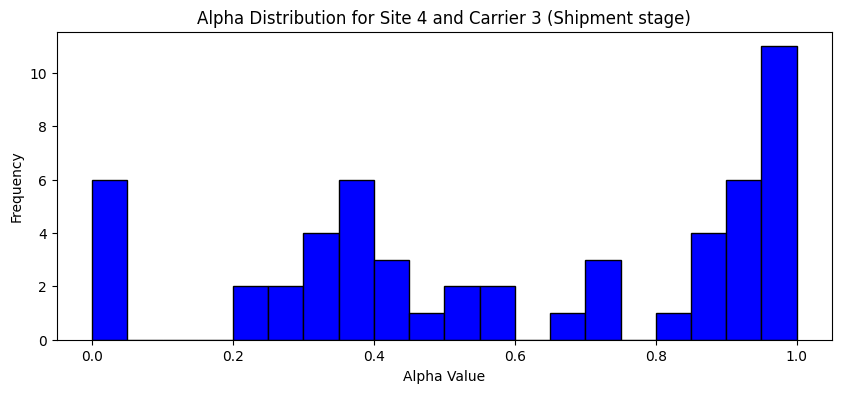

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
opt_df['alpha'].plot(kind='hist', bins=20, title=f"Alpha Distribution for Site {site_id} and Carrier {carrier_id} (Shipment stage)", ax=ax, edgecolor='black', color='blue')

ax.set_xlabel("Alpha Value")
ax.set_ylabel("Frequency")
plt.show()

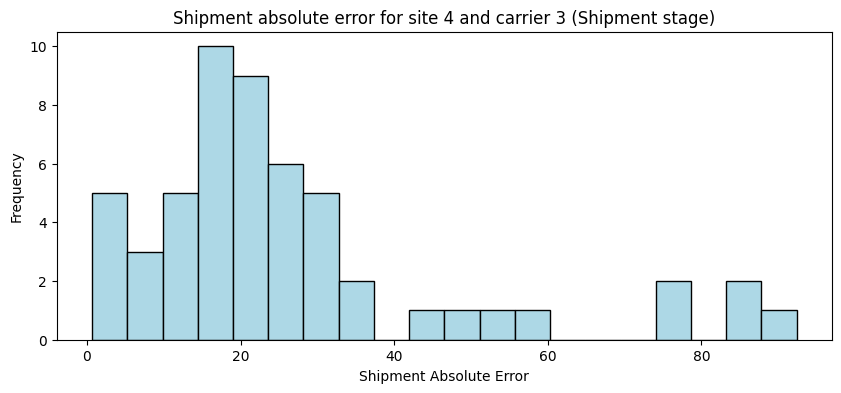

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
opt_df['shipment_ae'].plot(kind='hist', bins=20, title=f"Shipment absolute error for site {site_id} and carrier {carrier_id} (Shipment stage)", ax=ax, edgecolor='black', color='lightblue')

ax.set_xlabel("Shipment Absolute Error")
ax.set_ylabel("Frequency")
plt.show()

### Optimization

#### EST error minimization

In [17]:
def mse(y: np.ndarray, y_target: np.ndarray) -> np.float32:
    return np.mean((y - y_target) ** 2)

def mae(y: np.ndarray, y_target: np.ndarray) -> np.float32:
    return np.mean(np.abs(y - y_target))

loss_functions: Dict[str, Callable] = {
    'mse': mse,
    'mae': mae
}

In [18]:
def est_obj_func(tt_weight: float, tau: np.ndarray, TT: np.ndarray, PT: np.ndarray, shipment_t: np.ndarray, shipment_time: np.ndarray, loss: Callable) -> float:
    alpha_v = alpha(tau, tt_weight)
    est = alpha_v * TT + (1. - alpha_v) * PT     
    remaining_time = shipment_time - shipment_t
    return loss(est, remaining_time)

In [19]:
from scipy.optimize import minimize_scalar

EPS: float = 1e-6
loss: str = "mse"

alpha_opt_est_df: pd.DataFrame = alpha_opt_df.copy()

for i, row in alpha_opt_est_df.iterrows():
    site_id: int = row['site_id']
    carrier_id: int = row['carrier_id']

    # Filter relevant data
    opt_df: pd.DataFrame = df[
        (df['site_id'] == site_id) &
        (df['carrier_id'] == carrier_id) &
        (df['status'] != "DISPATCH")
    ].copy().reset_index(drop=True)

    tau_vec: np.ndarray = opt_df['tau'].to_numpy()
    tt_vec: np.ndarray = opt_df['TT'].to_numpy()
    pt_vec: np.ndarray = opt_df['PT'].to_numpy()
    shipment_t_vec: np.ndarray = opt_df['shipment_t'].to_numpy()
    shipment_time_vec: np.ndarray = opt_df['shipment_time'].to_numpy()

    # Objective function for scalar optimization
    obj_func_scalar: Callable = lambda alpha: est_obj_func(
        alpha,
        tau_vec,
        tt_vec,
        pt_vec,
        shipment_t_vec,
        shipment_time_vec,
        loss=loss_functions[loss]
    )

    # Optimize using minimize_scalar with bounds
    min_result: Any = minimize_scalar(
        fun=obj_func_scalar,
        bounds=(0.0, 1.0),
        method='bounded',
        options={'xatol': EPS}
    )

    # Store the optimal TT weight
    alpha_opt_est_df.at[i, 'tt_weight'] = min_result.x

alpha_opt_est_df

site_id  carrier_id  n_orders  tt_weight
1         4           3         4   0.150806
12        1           2         4   0.021380
15        3           2        53   0.180933

In [20]:
def plot_est_optimization_results(site_id: int, carrier_id: int, metric: str) -> None:
    opt_df: pd.DataFrame = df[(df['site_id'] == site_id) & (df['carrier_id'] == carrier_id) & (df['status'] != "DISPATCH")].reset_index(drop=True)
    tau_vec: np.ndarray = opt_df['tau'].to_numpy()
    tt_vec: np.ndarray = opt_df['TT'].to_numpy()
    pt_vec: np.ndarray = opt_df['PT'].to_numpy()
    shipment_t_vec: np.ndarray = opt_df['shipment_t'].to_numpy()
    shipment_time_vec: np.ndarray = opt_df['shipment_time'].to_numpy()

    opt_tt_weight: float = alpha_opt_est_df[(alpha_opt_est_df['site_id'] == site_id) & (alpha_opt_est_df['carrier_id'] == carrier_id)]['tt_weight'].values[0]

    tt_weight_vec: np.ndarray = np.linspace(0, 1, 5000, endpoint=False)
    obj_vals_data: List[float] = []
    for i in range(len(tt_weight_vec)):
        objective_val: float = est_obj_func(tt_weight_vec[i], tau_vec, tt_vec, pt_vec, shipment_t_vec, shipment_time_vec, loss_functions[loss])
        obj_vals_data.append(objective_val)

    obj_vals: np.ndarray = np.array(obj_vals_data)

    plt.figure(figsize=(10, 3))
    plt.plot(tt_weight_vec, obj_vals, 'b-', linewidth=2, label=f'Objective Function')
    plt.axvline(x=opt_tt_weight, color='r', linestyle='--', label='Optimal $\\langle TT \\rangle$')
    plt.xlabel('$\\langle TT \\rangle$')
    plt.ylabel(f'{metric}'.upper())
    plt.title(f'Functional Alpha Optimization (Site {site_id} - Carrier {carrier_id})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

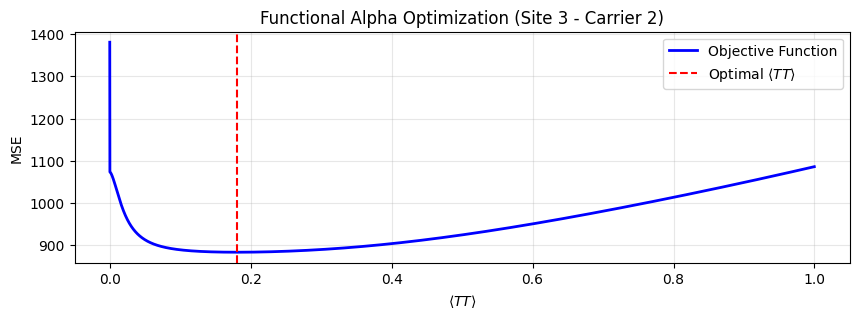

In [21]:
plot_est_optimization_results(3, 2, loss)

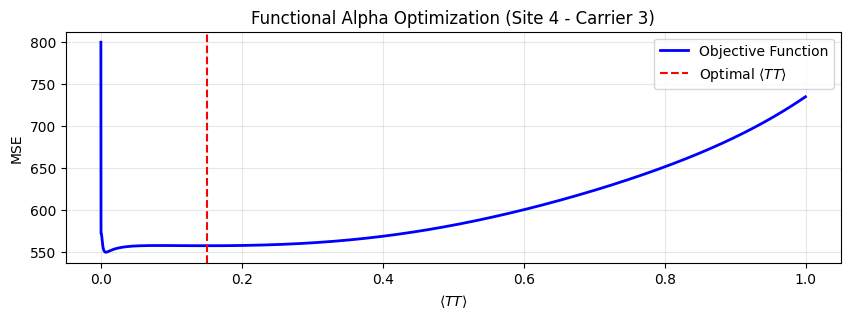

In [22]:
plot_est_optimization_results(4, 3, loss)

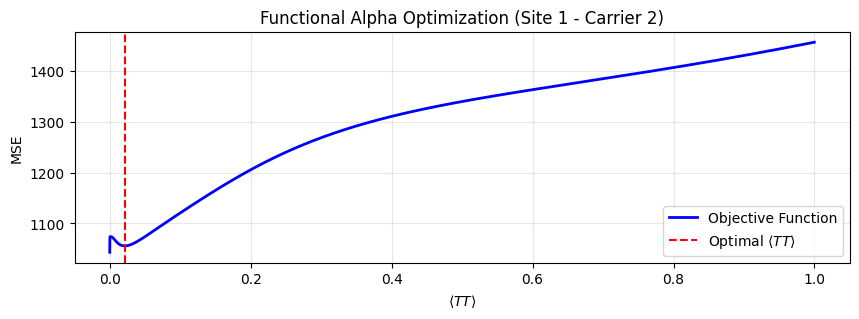

In [23]:
plot_est_optimization_results(1, 2, loss)

In [24]:
import scipy.stats as stats

loc: float = 21.282943184186703
scale: float = 31.021468212563512
shape: float = 1.211886691269898

gamma = stats.gamma(a=shape, loc=loc, scale=scale)
gamma.mean(), gamma.std(), gamma.std() / gamma.mean()

(np.float64(58.87744765464461),
 np.float64(34.15020827751109),
 np.float64(0.5800218867812473))

#### TFST window error minimization

In [25]:
def mae_windowed(lower_v: np.ndarray, upper_v: np.ndarray, y_target_v: np.ndarray, penalty: float) -> float:
    assert len(lower_v) == len(upper_v) == len(y_target_v), "Input arrays must have the same length" 
    y_v: np.ndarray = (lower_v + upper_v) / 2
    loss: float = 0.0
    for l, u, y, y_target in zip(lower_v, upper_v, y_v, y_target_v):
        mult: float = 1.0 if l <= y_target <= u else penalty
        loss += abs(y - y_target) * mult
        
    return loss / len(y_target_v)
    
def mse_windowed(lower_v: np.ndarray, upper_v: np.ndarray, y_target_v: np.ndarray, penalty: float) -> float:
    assert len(lower_v) == len(upper_v) == len(y_target_v), "Input arrays must have the same length" 
    y_v: np.ndarray = (lower_v + upper_v) / 2
    loss: float = 0.0
    for l, u, y, y_target in zip(lower_v, upper_v, y_v, y_target_v):
        mult: float = 1.0 if l <= y_target <= u else penalty
        loss += (y - y_target) ** 2 * mult
    
    return loss / len(y_target_v)

loss_functions['mse_windowed'] = mse_windowed
loss_functions['mae_windowed'] = mae_windowed

In [26]:
PENALTY: float = 5.0

def tfst_obj_func(tt_weight: float, 
                  tau: np.ndarray, 
                  TT_lower: np.ndarray, TT_upper: np.ndarray,
                  PT_lower: np.ndarray, PT_upper: np.ndarray, 
                  shipment_t: np.ndarray, 
                  shipment_time: np.ndarray, 
                  loss: Callable
                  ) -> float:
    
    alpha_v = alpha(tau, tt_weight)
    tfst_lower: np.ndarray = alpha_v * TT_lower + (1. - alpha_v) * PT_lower
    tfst_upper: np.ndarray = alpha_v * TT_upper + (1. - alpha_v) * PT_upper     
    remaining_time: np.ndarray = shipment_time - shipment_t
    
    return loss(lower_v=tfst_lower, upper_v=tfst_upper, y_target_v=remaining_time, penalty=PENALTY)

In [27]:
loss: str = "mse_windowed"

alpha_opt_tfst_df: pd.DataFrame = alpha_opt_df.copy()
for i, row in alpha_opt_tfst_df.iterrows():
    site_id: int = row['site_id']
    carrier_id: int = row['carrier_id']
    initial_alpha: float = 0.5
    
    opt_df: pd.DataFrame = df[(df['site_id'] == site_id) & (df['carrier_id'] == carrier_id) & (df['status'] != "DISPATCH")].copy().reset_index(drop=True)

    tau_vec: np.ndarray = opt_df['tau'].to_numpy()
    tt_lower_vec: np.ndarray = opt_df['TT_lower'].to_numpy()
    tt_upper_vec: np.ndarray = opt_df['TT_upper'].to_numpy()
    pt_lower_vec: np.ndarray = opt_df['PT_lower'].to_numpy()
    pt_upper_vec: np.ndarray = opt_df['PT_upper'].to_numpy()
    shipment_t_vec: np.ndarray = opt_df['shipment_t'].to_numpy()
    shipment_time_vec: np.ndarray = opt_df['shipment_time'].to_numpy()

    obj_func_wrapper: Callable = lambda x_vec: tfst_obj_func(
        x_vec[0],
        tau_vec,
        tt_lower_vec, tt_upper_vec,
        pt_lower_vec, pt_upper_vec,
        shipment_t_vec,
        shipment_time_vec,
        loss=loss_functions[loss]
    )

    min_result: Any = minimize(
        fun=obj_func_wrapper,
        x0=[initial_alpha],
        bounds=[(0, 1)],
        method='SLSQP'    #'L-BFGS-B',
    )

    alpha_opt_tfst_df.at[i, 'tt_weight'] = min_result.x[0]

alpha_opt_tfst_df

site_id  carrier_id  n_orders  tt_weight
1         4           3         4   0.419649
12        1           2         4   0.000000
15        3           2        53   0.484526

In [28]:
def plot_tfst_optimization_results(site_id: int, carrier_id: int, metric: str) -> None:
    opt_df: pd.DataFrame = df[(df['site_id'] == site_id) & (df['carrier_id'] == carrier_id) & (df['status'] != "DISPATCH")].reset_index(drop=True)
    tau_vec: np.ndarray = opt_df['tau'].to_numpy()
    tt_lower_vec: np.ndarray = opt_df['TT_lower'].to_numpy()
    tt_upper_vec: np.ndarray = opt_df['TT_upper'].to_numpy()
    pt_lower_vec: np.ndarray = opt_df['PT_lower'].to_numpy()
    pt_upper_vec: np.ndarray = opt_df['PT_upper'].to_numpy()
    shipment_t_vec: np.ndarray = opt_df['shipment_t'].to_numpy()
    shipment_time_vec: np.ndarray = opt_df['shipment_time'].to_numpy()

    opt_tt_weight: float = alpha_opt_tfst_df[(alpha_opt_tfst_df['site_id'] == site_id) & (alpha_opt_tfst_df['carrier_id'] == carrier_id)]['tt_weight'].values[0]

    tt_weight_vec: np.ndarray = np.linspace(0, 1, 1000)
    obj_vals_data: List[float] = []
    for i in range(len(tt_weight_vec)):
        objective_val: float = tfst_obj_func(tt_weight_vec[i], tau_vec, tt_lower_vec, tt_upper_vec, pt_lower_vec, pt_upper_vec, shipment_t_vec, shipment_time_vec, loss_functions[loss])
        obj_vals_data.append(objective_val)

    obj_vals: np.ndarray = np.array(obj_vals_data)

    plt.figure(figsize=(10, 3))
    plt.plot(tt_weight_vec, obj_vals, 'b-', linewidth=2, label=f'Objective Function')
    plt.axvline(x=opt_tt_weight, color='r', linestyle='--', label='Optimal Value')
    plt.xlabel('Transit Time Weight')
    plt.ylabel(f'{metric}'.upper())
    plt.title(f'TFST Optimization for Site {site_id} and Carrier {carrier_id}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

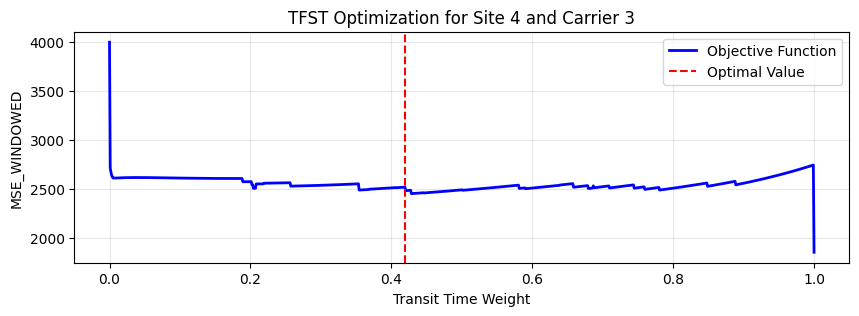

In [29]:
plot_tfst_optimization_results(4, 3, loss)

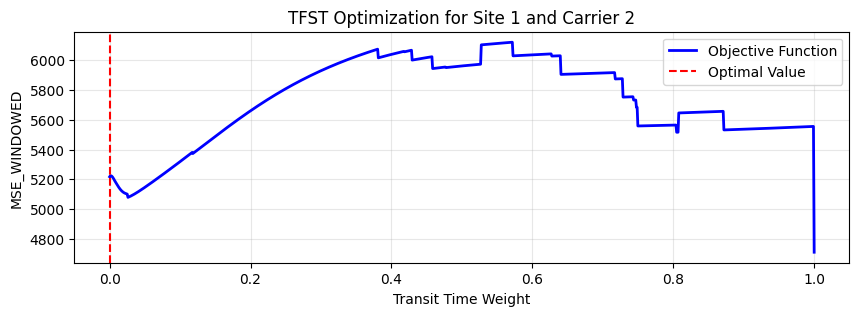

In [30]:
plot_tfst_optimization_results(1, 2, loss)

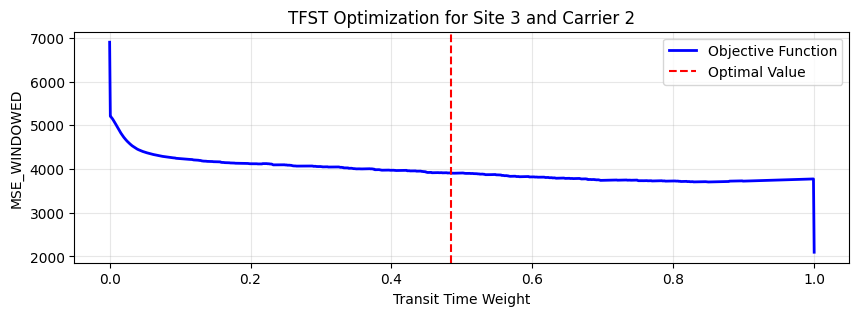

In [31]:
plot_tfst_optimization_results(3, 2, loss)

## Model parameters update

In [32]:
API_URL = "https://rhwompporf.execute-api.eu-central-1.amazonaws.com/dev"
ROOT_URL = f"{API_URL}/"


DB_URL = f"{ROOT_URL}db"
ALPHA_OPT_URL = f"{DB_URL}/tables/alphas_opt"

In [33]:
ALPHA_OPT_PATH: str = f"{CSV_PATH}/alphas_opt.csv"
ALPHA_OPT_PATH

'C:/P/backend/LambdaPY/graph_manager/builder_service/local/csv_test/alphas_opt.csv'

In [34]:
alpha_opt_choosen_df: pd.DataFrame = alpha_opt_tfst_df.copy().reset_index(drop=True)
alpha_opt_choosen_df

site_id  carrier_id  n_orders  tt_weight
0        4           3         4   0.419649
1        1           2         4   0.000000
2        3           2        53   0.484526

In [40]:
if 'id' in alpha_opt_all_df.columns:
    alpha_opt_all_df.drop(columns=['id'])

alpha_opt_all_df['tt_weight'] = 0.5
alpha_opt_all_df.loc[
    (alpha_opt_all_df['site_id'] == 3) & (alpha_opt_all_df['carrier_id'] == 2),
    'tt_weight'
] = 0.1809

alpha_opt_all_df = alpha_opt_all_df[['site_id', 'carrier_id', 'tt_weight']]
alpha_opt_all_df = alpha_opt_all_df.reset_index(drop=True).sort_values(by=['site_id', 'carrier_id'])
alpha_opt_all_df

site_id  carrier_id  tt_weight
0         1           2     0.5000
1         2           2     0.5000
2         3           2     0.1809
3         4           3     0.5000
4         5           3     0.5000
5         6           3     0.5000
6         7           4     0.5000
7         8           1     0.5000
8         8           3     0.5000
9         9           1     0.5000
10       10           1     0.5000
11       11           3     0.5000
12       12           4     0.5000
13       13           4     0.5000
14       14           3     0.5000
15       15           4     0.5000
16       16           4     0.5000
17       17           4     0.5000
18       18           4     0.5000
19       19           4     0.5000
20       20           1     0.5000
21       21           3     0.5000

In [41]:
alpha_opt_all_df.to_csv(ALPHA_OPT_PATH, index=False)

In [42]:
request_data: List[Dict[Any, Any]] = alpha_opt_all_df.to_dict(orient='records')
request_data

[{'site_id': 1, 'carrier_id': 2, 'tt_weight': 0.5},
 {'site_id': 2, 'carrier_id': 2, 'tt_weight': 0.5},
 {'site_id': 3, 'carrier_id': 2, 'tt_weight': 0.1809},
 {'site_id': 4, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 5, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 6, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 7, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 8, 'carrier_id': 1, 'tt_weight': 0.5},
 {'site_id': 8, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 9, 'carrier_id': 1, 'tt_weight': 0.5},
 {'site_id': 10, 'carrier_id': 1, 'tt_weight': 0.5},
 {'site_id': 11, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 12, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 13, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 14, 'carrier_id': 3, 'tt_weight': 0.5},
 {'site_id': 15, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 16, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 17, 'carrier_id': 4, 'tt_weight': 0.5},
 {'site_id': 18, 'carrier_id': 4, 'tt_weight': 0.5},


In [43]:
def update_alpha_opt_records(data: List[Dict]) -> List[Dict[str, Any]]:
    response: requests.Response = requests.delete(
        f"{DB_URL}/tables/alphas_opt/all-records",
        json={"confirmDeleteAll": True, "tableNameConfirmation": "alphas_opt"},
        headers={'Content-Type': 'application/json'}
    )
    response.raise_for_status()
    
    response: requests.Response = requests.post(
        ALPHA_OPT_URL,
        json={"data": data},
        headers={'Content-Type': 'application/json'}
    )
    response.raise_for_status()
    return response.json()

In [44]:
update_alpha_opt_records(request_data)

{'success': True,
 'message': 'Successfully inserted 22 record(s)',
 'data': [{'id': 465,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at': '2025-08-29T20:09:59.436Z',
   'site_id': 1,
   'carrier_id': 2,
   'tt_weight': '0.500000'},
  {'id': 466,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at': '2025-08-29T20:09:59.436Z',
   'site_id': 2,
   'carrier_id': 2,
   'tt_weight': '0.500000'},
  {'id': 467,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at': '2025-08-29T20:09:59.436Z',
   'site_id': 3,
   'carrier_id': 2,
   'tt_weight': '0.180900'},
  {'id': 468,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at': '2025-08-29T20:09:59.436Z',
   'site_id': 4,
   'carrier_id': 3,
   'tt_weight': '0.500000'},
  {'id': 469,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at': '2025-08-29T20:09:59.436Z',
   'site_id': 5,
   'carrier_id': 3,
   'tt_weight': '0.500000'},
  {'id': 470,
   'created_at': '2025-08-29T20:09:59.436Z',
   'updated_at'

In [39]:
RESTORE_STANDARD_ALPHAS_OPT = True

if RESTORE_STANDARD_ALPHAS_OPT:
    alpha_opt_all_df['tt_weight'] = 0.5
    alpha_opt_all_df.to_csv(ALPHA_OPT_PATH, index=False)
    request_data: List[Dict[Any, Any]] = alpha_opt_all_df.to_dict(orient='records')
    response = update_alpha_opt_records(request_data)
    print("Standard alphas_opt restored with tt_weight = 0.5")
else:
    response = None
    print("Standard alphas_opt restoration skipped.")

response

Standard alphas_opt restored with tt_weight = 0.5


{'success': True,
 'message': 'Successfully inserted 22 record(s)',
 'data': [{'id': 443,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at': '2025-08-29T19:27:41.457Z',
   'site_id': 1,
   'carrier_id': 2,
   'tt_weight': '0.500000'},
  {'id': 444,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at': '2025-08-29T19:27:41.457Z',
   'site_id': 2,
   'carrier_id': 2,
   'tt_weight': '0.500000'},
  {'id': 445,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at': '2025-08-29T19:27:41.457Z',
   'site_id': 3,
   'carrier_id': 2,
   'tt_weight': '0.500000'},
  {'id': 446,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at': '2025-08-29T19:27:41.457Z',
   'site_id': 4,
   'carrier_id': 3,
   'tt_weight': '0.500000'},
  {'id': 447,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at': '2025-08-29T19:27:41.457Z',
   'site_id': 5,
   'carrier_id': 3,
   'tt_weight': '0.500000'},
  {'id': 448,
   'created_at': '2025-08-29T19:27:41.457Z',
   'updated_at'